# Introduction

Why we use a [Jupyter](https://en.wikipedia.org/wiki/Project_Jupyter) notebook to to publish the R program examples:

Jupyter is a new **open source** alternative to the proprietary numerical software [Mathematica](https://en.wikipedia.org/wiki/Wolfram_Mathematica) from **Wolfram Research** that is well on the way to become a **standard for exchanging research results** (<cite data-cite="Scientific_Paper_obsolete_2018">Somers, 2018</cite>; <cite data-cite="Future_of_Research_Paper_2018">Romer, 2018</cite>).

Originally Jupyter was intended as an IDE for the programming languages **Julia** and **Python**. Besides that it is also possible to install other interpreter kernels, such as the **[IRkernel](https://irkernel.github.io/installation/)** for R. This can be interesting if the IDE **RStudio Desktop** is not available on the target platform used. For example, it is very difficult to install RStudio on the ARM-based embedded computer **Raspberry Pi** due to many technical dependencies. In contrast, using the R kernel in JupyterLab on the Raspberry Pi works very well and performant.

# Loading of used R packages and definition of global functions

## Install missing packages if not present yet

In order to load the R packages used in the next sections, they must be installed in the R environment. The following function checks for the presence of the packages and installs the missing ones.

**Attention:** For some R packages, several dependencies have to be installed first using the package manager of the operating system, e.g. `apt install <package name>`.

In general, the use of R version $\geq$ 4.0 is strongly recommended. In particular, the `ahpsurvey` package, which is essential for calculating the AHP, depends on the `randomNames` package. However, this is only available starting with R version $\geq$ 4.0 (refer to [randomNames: Generate Random Given and Surnames](https://cran.r-project.org/web/packages/randomNames/index.html)).

This can be problematic especially with slightly older systems, e.g. on the operating system **Raspbian buster** for the very well-known **Raspberry Pi**, R is only available in version 3.5.2. Upgrading R in Raspbian following the instructions on [https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable](https://cran.rstudio.com/bin/linux/debian/#debian-buster-stable) has not succeeded for the authors so far.

In [2]:
# List of R packages that are used in this script
list.of.packages <- c("data.table",
                      "ggplot2",
                      "tidyr",
                      "dplyr",
                      "magrittr",
                      "ahpsurvey",
                      "knitr",
                      "IRdisplay",
                      "forcats")

# Query the already installed packages and save the missing ones in a new list
missing.packages <- list.of.packages[!(list.of.packages 
                                       %in% installed.packages()[,"Package"])]

# Install missing packages
if(length(missing.packages)) {
    install.packages(missing.packages)
} else {
    print("All required packages are installed.")
}

[1] "All required packages are installed."


## Load R packages

After proving in the previous section that all required R packages are installed, they can be loaded in the following subsections.

### Load package `data.table`

The `data.table` package is used for **reading and editing tables**.

**Note:** This package inherits from `data.frame`.

In [3]:
library(data.table)

### Load package `ggplot2`

The package `ggplot2` is used to **plot beautiful diagrams**.

In [4]:
library(ggplot2)

### Load packages `knitr` and `IRdisplay`

The `kable()` function from the package `knitr` is used to output dataframes as markdown tables.

The `display_markdown()` function from the package `IRdisplay` is used to **render markdown tables** in the notebook as well as in the compiled PDF output.

In [5]:
library(knitr)
library(IRdisplay)

### Load package `tidyr`

The package `tidyr` is used to **reshape dataframes** and provides functions like `gather()` or `spread()`. Some examples for the application can be found here: [Reshaping your data with tidyr](https://uc-r.github.io/tidyr).

In [6]:
library(tidyr)

### Load package `dplyr`

The package `dplyr` is necessary to **manipulate dataframes** using functions like `select()`, `mutate()` and `left_join()`.

**Hint:** Annoying messages on package loading regarding masked functions can be suppressed by setting the parameter `warn.conflicts=FALSE` when calling the `library()` function.

In [7]:
library(dplyr, warn.conflicts=FALSE)

### Load package `magrittr`

The package `magrittr` provides the **pipe functionality** and can be used to create more effective code for processing large datasets. What pipes of the form like `%>%` are and how to use them is described here: [R-Programmierung: Was ist `%>%`?](https://statistik-dresden.de/archives/15679).

**HINT:** The pipe functionality is already available by loading the library `tidyr` - so you don't have to load it explicitly.

In [8]:
library(magrittr, warn.conflicts=FALSE)

### Load package `forcats`

The `fct_inorder()` function from the package `forcats` is used to **reorder the discrete levels of diagram axes** according to the intended order of attributes.

In [9]:
library(forcats)

### Load package `ahpsurvey`

The package `ahpsurvey` contains all the necessary mathematical and statistical methods to run the **analytical hierarchy process (AHP)**.

In [10]:
library(ahpsurvey)

## Function to format dataframes as markdown tables

Following function **formats given dataframes as markdown tables** using the `kable()` function from the `knitr` package.

The `display_markdown()` function from the package `IRdisplay` is used to **render markdown tables** in the notebook as well as in the compiled PDF output.

In [11]:
func_render_md_tables <- function(df_table, str_table_header) {
    # Format the dataframe as a markdown table using 
    # the 'kable()' function from the 'knitr' package.
    table_out <- kable(
        df_table,
        format = "markdown",
        # digits = 2,
        caption = str_table_header)

    # print(table_out)
    display_markdown(as.character(table_out))
}

# Prepare raw CSV input data from SoSci Survey for analytical hierarchy process (AHP)

The survey was conducted on the [SoSci Survey](https://www.soscisurvey.de/) platform and the results were exported as CSV files.

In this main section the CSV files are prepared in such a way that in the following main section the AHP can be carried out using the R package `ahpsurvey`.

## Set globally used input and output folders for preparing raw CSV data

The following global variables are used to store the input and output folders for CSV file preparation.

In [12]:
str_input_path_prep = "./input_data_from_survey"
str_output_path_prep = "./output_data_manipulated"

## Define functions to prepare the survey data for further analysis

The following functions are used to read the survey data from the input CSV files, to prepare the data structure for further analysis with the R package `ahpsurvey` and to store the results in the output CSV files.

### Function to read the survey data from CSV files to dataframe objects

This function reads a CSV file and stores the data in four different dataframes by selecting different columns for each. The four dataframes contain the **main criteria**, the **environmental**, the **social**, or the **economic sub-criteria**.

In [13]:
func_readCSVdata_to_dataframes <- function(str_CSVfilename) {
  
  # Criteria (main criteria)
  df_mySurvey_1 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.var = "CASE",
    select = c("CASE", "AK01", "AK02", "AK03",
               "RK01_01", "RK02_01", "RK03_01",
               "RK04_01", "RK05_01", "RK06_01")
    )
  
  # Environmental sub-criteria
  df_mySurvey_2 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AU01", "AU02", "AU03",
               "RU01_01", "RU02_01", "RU03_01",
               "RU04_01", "RU05_01", "RU06_01")
    )
  
  # Social sub-criteria
  df_mySurvey_3 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AS01", "AS02", "AS03",
               "RS01_01", "RS02_01", "RS03_01",
               "RS04_01", "RS05_01", "RS06_01")
    )
  
  # Economic sub-criteria
  df_mySurvey_4 <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\"",
    # dec = ".", row.names = "CASE",
    select = c("CASE", "AW01", "AW02", "AW03",
               "RW01_01", "RW02_01", "RW03_01",
               "RW04_01", "RW05_01", "RW06_01")
    )
  
  output <- list(df_mySurvey_1, df_mySurvey_2, df_mySurvey_3, df_mySurvey_4)
  
  return(output)
}

### Function to adapt the exported survey data to Saaty scale

For the **comparison of two attributes**, Saaty introduced a scale of nine rating items shown in the following table (see <cite data-cite="Saaty_AHP_1987">Saaty, 1987</cite>):

Table: Nine rating items according to Saaty (adapted from source: <cite data-cite="Vignettes_ahpsurvey_2019">Cho, 2019</cite>)

| Rating | Definition                                           |
|-------:|:-----------------------------------------------------|
| 1      | Two attributes are equally important                 |
| 2      | Between 1 and 3                                      |
| 3      | The preferred attribute is slightly more important   |
| 4      | Between 3 and 5                                      |
| 5      | The preferred attribute is moderately more important |
| 6      | Between 5 and 7                                      |
| 7      | The preferred attribute is strongly more important   |
| 8      | Between 7 and 9                                      |
| 9      | The preferred attribute is absolutely more important |

To be able to describe the comparison of two attributes uniquely, negative values as well as positive values are introduced for the rating items. **Negative** values prefer the $Attribute\;X$ and **positive** values the $Attribute\;Y$. A value of **$1$** means that both attributes are **equally weighted**, i.e. equally important. Note that the values $0$ and $\text{-}1$ **do not** exist. Thus, Saaty's 17-step scale will result as follows:

$$Attribute\;X\;\;\;\;\text{-}9\;\text{-}8\;\text{-}7\;\ldots\;\text{-}3\;\text{-}2\;\;\;\textbf{1}\;\;\;2\;3\;\ldots\;7\;8\;9\;\;\;\;Attribute\;Y$$

The package `ahpsurvey` employs the 17-step scale according to Saaty (see <cite data-cite="Vignettes_ahpsurvey_2019">Cho, 2019</cite>).

On the one hand, Saaty's 17-step scale was not technically well implementable on the survey platform used [SoSci Survey](https://www.soscisurvey.de/). On the other hand, it had been too fine-granular for the mostly non-scientific target groups of participants.

Therefore, a **2-stage query** was chosen as an alternative approach. In **stage 1**, it was first asked whether, and if so, which of the two attributes was preferred and thus given a higher weighting. Stage 1 resulted in the following encoding:

- $\text{-}1$: $Attribute\;X$ and $Attribute\;Y$ **equally important**
- $\;1$: $Attribute\;X$ **more important** than $Attribute\;Y$
- $\;2$: $Attribute\;X$ **less important** than $Attribute\;Y$

With different weightings, the respondents in **stage 2** had to decide how much more important the respective attribute was to them on a scale of 1 to 8. Thereby, 1 corresponds to 2, 2 to 3, etc. of the rating items according to Saaty. See the following figure:

![Transformation from the Saaty's 17-step scale to the encoded scale applied by a 2-stage query (source: Kasper, license: CC BY-SA 4.0)](images/Saaty_scale_to_SoSciSurvey.png)

The survey results were exported from *SoSci Survey* in the form of an **encoded scale** as a CSV file. With the following function `func_adaptData2SaatyScale` this now has to be converted back to the Saaty scale in order to run AHP with the R package `ahpsurvey`.

The values of the encoding and those of the weighting have to be taken from the CSV file from three different columns per pairwise attribute comparison. For example, when comparing the two attributes "Microclimate and Hydrology (Clim)" and "Biodiversity (BDiv)", the column `AU01` contains the encoding and the columns `RU01_01` or `RU02_01` the respective weighting.

The following example shows the three possible cases and the conversion to the Saaty scale.

**Case 1:**

- if `AU01` $= \text{-}1$, then set weighting $= 1$
- attributes `Clim` and `BDiv` are equally important
- values in columns `RU01_01` or `RU02_01` are ignored

**Case 2:**

- if `AU01` $= 1$, then set weighting $= \text{-}1\;*$ `RU01_01` $-\;1$
- the attribute `Clim` is more important than `BDiv`

**Case 3:**

- if `AU01` $= 2$, then set weighting $=$ `RU02_01` $+\;1$
- the attribute `Clim` is less important than `BDiv`

The function `func_adaptData2SaatyScale` returns a new dataframe with the weightings converted to the Saaty scale from three pairwise comparisons of the criteria or sub-criterion.

In [14]:
func_adaptData2SaatyScale <- function(df_inputData,
                                      vec_colnames_search_1,
                                      vec_colnames_search_2,
                                      vec_colnames_out) {
  # Generate new dataframe ...
  df_outputData <- data.frame(matrix(ncol = 3, nrow = 0))
  # ... and name the columns
  colnames(df_outputData) <- vec_colnames_out
  
  # Generate 1. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # Filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData)
        %in% vec_colnames_search_1[1], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[1], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1

      df_outputData[row_idx, vec_colnames_out[1]] <- int_tmp_val
    }
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[1], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[1]] <- 1
    }
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[1], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[2], with=FALSE])
      int_tmp_val <- int_tmp_val + 1

      df_outputData[row_idx, vec_colnames_out[1]] <- int_tmp_val
    }
  }
  
  # Generate 2. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # Filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData)
        %in% vec_colnames_search_1[2], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[3], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1
      
      df_outputData[row_idx, vec_colnames_out[2]] <- int_tmp_val
    } 
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[2], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[2]] <- 1
    } 
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[2], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[4], with=FALSE])
      int_tmp_val <- int_tmp_val + 1
      
      df_outputData[row_idx, vec_colnames_out[2]] <- int_tmp_val
    }
  }
  
  # Generate 3. column
  for ( row_idx in 1:nrow(df_inputData) ) {
    # Filter column names by vector element
    if (df_inputData[row_idx, colnames(df_inputData)
        %in% vec_colnames_search_1[3], with=FALSE] == 1) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[5], with=FALSE])
      int_tmp_val <- int_tmp_val * -1 - 1
      
      df_outputData[row_idx, vec_colnames_out[3]] <- int_tmp_val
    } 
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[3], with=FALSE] == -1) {
      df_outputData[row_idx, vec_colnames_out[3]] <- 1
    } 
    else if (df_inputData[row_idx, colnames(df_inputData)
             %in% vec_colnames_search_1[3], with=FALSE] == 2) {
      int_tmp_val <- as.integer(df_inputData[row_idx, colnames(df_inputData)
                     %in% vec_colnames_search_2[6], with=FALSE])
      int_tmp_val <- int_tmp_val + 1
      
      df_outputData[row_idx, vec_colnames_out[3]] <- int_tmp_val
    }
  }
  
  # Return rescaled dataframe
  return(df_outputData)
}

### Function to write resulting dataframes to CSV files

With this function, the results of the data preparation are saved in output CSV files.

In [15]:
func_writeDataframe_to_CSVfile <- function(str_path, str_CSVfilename,
                                           df_dataframe, str_filenameExtension) {
  # How to split the file name on second underscore,
  # was found here: https://stackoverflow.com/a/32398489
  list_str_split <- strsplit(sub('(^[^_]+_[^_]+)_(.*)$', '\\1 \\2',
                                 str_CSVfilename), ' ')
  
  # Extend the file name prefix and glue together with old suffix
  str_CSVfilename_extended <- paste(list_str_split[[1]][1],
                                    str_filenameExtension,
                                    list_str_split[[1]][2], sep="_")
  
  # Extend file name by path
  str_CSVfilename_extended <- paste(str_path, str_CSVfilename_extended, sep="/")
  
  write.table(df_dataframe, file = str_CSVfilename_extended,
              fileEncoding = "UTF-8", row.names = FALSE,
              col.names = TRUE, sep = "\t", quote = TRUE)
}

## Create dataframe handling the file names of input CSV data (raw data from survey)

In [16]:
df_csvInputFiles <- data.table(
  file_idx = 1:4,
  keys = c("all", "CA", "NGO", "PE"),
  filenames = c("rdata_all_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_CA_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_NGO_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_PE_AHP_edible_Cities_2022-03-18_10-41.csv"),
  descriptions = c("all target groups together",
                   "City Administrations",
                   "Non-Governmental Organisations",
                   "Practitioners and Experts")
)

func_render_md_tables(df_csvInputFiles, "File table for handling the file names 
                      of input CSV data (raw data from survey)")

Table: File table for handling the file names 
                      of input CSV data (raw data from survey)

| file_idx|keys |filenames                                        |descriptions                   |
|--------:|:----|:------------------------------------------------|:------------------------------|
|        1|all  |rdata_all_AHP_edible_Cities_2022-03-18_09-53.csv |all target groups together     |
|        2|CA   |rdata_CA_AHP_edible_Cities_2022-03-18_10-28.csv  |City Administrations           |
|        3|NGO  |rdata_NGO_AHP_edible_Cities_2022-03-18_10-40.csv |Non-Governmental Organisations |
|        4|PE   |rdata_PE_AHP_edible_Cities_2022-03-18_10-41.csv  |Practitioners and Experts      |

## Prepare the data and store it in new CSV files for each criterion

### Criteria (main criteria)

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [17]:
vec_colnames_search_1 <- c('AK01', 'AK02', 'AK03')
vec_colnames_search_2 <- c('RK01_01', 'RK02_01', 'RK03_01',
                           'RK04_01', 'RK05_01', 'RK06_01')
vec_colnames_out <- c('Envi_Soci', 'Envi_Econ', 'Soci_Econ')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # Create a list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep,
                        df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # Adapt the encoded scale of the survey to the 17-step Saaty's scale
  # in the input dataframes
  df_surveyData_rescaled <- func_adaptData2SaatyScale(list_dataframes[[1]],
                                                      vec_colnames_search_1,
                                                      vec_colnames_search_2,
                                                      vec_colnames_out)
  
  # Write rescaled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep,
                                 df_csvInputFiles[row_idx, filenames],
                                 df_surveyData_rescaled, "crit")
}

### Environmental sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [18]:
vec_colnames_search_1 <- c('AU01', 'AU02', 'AU03')
vec_colnames_search_2 <- c('RU01_01', 'RU02_01',
                           'RU03_01', 'RU04_01',
                           'RU05_01', 'RU06_01')
vec_colnames_out <- c('Clim_BDiv', 'Clim_CiEc', 'BDiv_CiEc')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # Create a list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep,
                        df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # Adapt the encoded scale of the survey to the 17-step Saaty's scale
  # in the input dataframes
  df_surveyData_rescaled <- func_adaptData2SaatyScale(list_dataframes[[2]],
                                                      vec_colnames_search_1,
                                                      vec_colnames_search_2,
                                                      vec_colnames_out)
  
  # Write rescaled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep,
                                 df_csvInputFiles[row_idx, filenames],
                                 df_surveyData_rescaled, "env")
}

### Social sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [19]:
vec_colnames_search_1 <- c('AS01', 'AS02', 'AS03')
vec_colnames_search_2 <- c('RS01_01', 'RS02_01', 'RS03_01',
                           'RS04_01', 'RS05_01', 'RS06_01')
vec_colnames_out <- c('KEdu_Comm', 'KEdu_Part', 'Comm_Part')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # Create a list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep,
                        df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # Adapt the encoded scale of the survey to the 17-step Saaty's scale
  # in the input dataframes
  df_surveyData_rescaled <- func_adaptData2SaatyScale(list_dataframes[[3]],
                                                      vec_colnames_search_1,
                                                      vec_colnames_search_2,
                                                      vec_colnames_out)
  
  # Write rescaled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep,
                                 df_csvInputFiles[row_idx, filenames],
                                 df_surveyData_rescaled, "soc")
}

### Economic sub-criteria

Walk over all input CSV files, select necessary columns, filter cells by given algorithm, and write the results to output CSV files:

In [40]:
vec_colnames_search_1 <- c('AW01', 'AW02', 'AW03')
vec_colnames_search_2 <- c('RW01_01', 'RW02_01', 'RW03_01',
                           'RW04_01', 'RW05_01', 'RW06_01')
vec_colnames_out <- c('Qual_LVCs', 'Qual_Affo', 'LVCs_Affo')

for ( row_idx in 1:nrow(df_csvInputFiles) ) {
  # Create a list of dataframes from current input CSV file
  str_filename <- paste(str_input_path_prep,
                        df_csvInputFiles[row_idx, filenames], sep="/")
  list_dataframes <- func_readCSVdata_to_dataframes(str_filename)
  
  # Adapt the encoded scale of the survey to the 17-step Saaty's scale
  # in the input dataframes
  df_surveyData_rescaled <- func_adaptData2SaatyScale(list_dataframes[[4]],
                                                      vec_colnames_search_1,
                                                      vec_colnames_search_2,
                                                      vec_colnames_out)
  
  # Write rescaled dataframes to output CSV file
  func_writeDataframe_to_CSVfile(str_output_path_prep,
                                 df_csvInputFiles[row_idx, filenames],
                                 df_surveyData_rescaled, "eco")
}

# Application of the processed survey data in the analytical hierarchy process (AHP)

## Set globally used input and output folders for processing AHP

In [21]:
str_input_path_ahp = "./output_data_manipulated"
str_output_path_ahp = "./output_data_AHP"

## Define functions for processing AHP

### Function to read in the processed survey data from CSV files to dataframes

Define a function for reading in a CSV file to a date frame.

In [22]:
func_readCSVdata_to_dataframe <- function(str_CSVfilename) {
  
  df_CSVdata <- fread(
    file = str_CSVfilename, encoding = "UTF-8",
    header = TRUE, sep = "\t", quote = "\""
    )
  
  return(df_CSVdata)
}

### Function to generate a dataframe with *eigentrue values* (weights)

In [23]:
func_genEigentrue_to_dataframe <- function(df_surveyData, vec_attributes) {
  list_mat_judgement <- df_surveyData %>% 
    ahp.mat(vec_attributes, negconvert = TRUE)
  
  df_eigentrue <- ahp.indpref(list_mat_judgement,
                              vec_attributes, method = "eigen")

  return(df_eigentrue)
}

### Function to generate an array with consistency ratios

In [24]:
func_genCR_to_arr <- function(df_surveyData, vec_attributes) {
  arr_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58)

  return(arr_cr)
}

### Function to generate a dataframe with consistency ratios

In [25]:
func_genCR_to_dataframe <- function(df_surveyData, vec_attributes,
                                    arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr),
           arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # Rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  return(df_cr)
}

### Function to visualize individual priorities and consistency ratios

In [26]:
func_visuPriosCRs <- function(df_surveyData, df_cr, arr_cr,
                              consistency_thres = 0.1, vec_attributes,
                              df_eigentrue, vec_labels,
                              str_image_filename, str_title) {
  # Select columns 'arr_cr.dum' and 'rowid' from input dataframe 'df_cr'
  # 'arr_cr.dum': Binary representation of the consistency ratio 
  #               (0: inconsistent; 1: consistent)
  df_cr_sel <- df_cr %>%
    select(arr_cr.dum, rowid)

  # Generate AHP pairwise matrices from survey data
  mat_ahp <- ahp.mat(df_surveyData, atts = vec_attributes, negconvert = TRUE)

  # Compute priority weights of individual decision-makers
  df_prio_weights <- ahp.indpref(mat_ahp, vec_attributes, method = "eigen")

  # Add column 'rowid' from dataframe 'df_eigentrue'
  df_prio_weights <- mutate(df_prio_weights, rowid = 1:nrow(df_eigentrue))

  # Left join dataframes 'df_prio_weights' and 'df_cr_sel' by column 'rowid'
  df_prio_weights_binCR <- left_join(df_prio_weights, df_cr_sel, by = "rowid")

  # Gather columns of 'df_prio_weights_binCR' into key-value pairs
  # The function 'all_of(vec_attributes)' selects data-variables listed
  # in the character vector 'vec_attributes'
  li_binCR_attr_weights <- gather(df_prio_weights_binCR,
                                  all_of(vec_attributes),
                                  key = "var", value = "pref")

  # Create the violin plots with overlaid box plots.
  # Important: The function "fct_inorder()" is necessary to reorder 
  # the discrete levels of the diagram axes according to 
  # the intended order of the attributes.
  # Otherwise, the order will be automatically set alphanumerically 
  # and will not match the attribute labels later.
  # refer: https://stackoverflow.com/a/41417136
  plt <- ggplot(li_binCR_attr_weights, aes(x = fct_inorder(var), y = pref)) +
    # Add a violin plot
    geom_violin(alpha = 0.6, width = 0.8, color = "transparent", fill = "gray") +
    # 'geom_jitter()' is a shortcut for 'geom_point(position = "jitter")'
    # Adds a small amount of random variation to the location of each point
    # to handle overplotting caused by discreteness in smaller datasets
    geom_jitter(alpha = 0.6, height = 0, width = 0.1, aes(color = arr_cr.dum)) +
    # Add a box plot
    geom_boxplot(alpha = 0, width = 0.3, color = "#808080") +
    # Set discrete levels of the diagram X-axis according to 
    # the corresponding attribute labels
    scale_x_discrete("Attribute", label = vec_labels) +

    # Configure the diagram Y-axis to display continuos data with
    # scale in percent and choose where the ticks appear by setting 'breaks'
    scale_y_continuous("Weight (dominant eigenvalue)", 
                         labels = scales::percent, 
                         breaks = c(seq(0,0.7,0.1))) +

    # Hide the title of the legend
    guides(color=guide_legend(title=NULL)) +

    # Set the discrete color scale according to the binarized consistency ratio
    # and use the Unicode character '\u2264' for '<='
    scale_color_discrete(breaks = c(0,1), 
                         labels = c(paste("CR >", consistency_thres), 
                                    paste("CR \u2264", consistency_thres))) +

    # Set caption text to be displayed in the bottom-right of the plot
    # with number of rows and mean value of the consistency ratio
    labs(NULL, caption = paste("n =", nrow(df_surveyData), ",", "Mean CR =",
                               round(mean(arr_cr), 3))) +

    # Set theme of the plot to 'theme_light()'
    theme_light() +

    # Set the title of the diagram
    ggtitle(str_title)

  print(plt)

  # Save generated ggplot graphics to PNG image files
  ggsave(filename = str_image_filename, width = 7, height = 7, dpi = 300)
}

### Function to generate geometric mean values from individual judgement matrices

In [27]:
func_aggpref_gmean <- function(df_surveyData, vec_attributes,
                               arr_cr, consistency_thres=0.1, str_CRlabel) {
  df_cr <- df_surveyData %>%
    ahp.mat(vec_attributes, negconvert = TRUE) %>% 
    ahp.cr(vec_attributes, ri=0.58) %>% 
    data.frame() %>%
    mutate(rowid = 1:length(arr_cr),
           arr_cr.dum = as.factor(ifelse(arr_cr <= consistency_thres, 1, 0)))
  
  # Rename column with consistency ratios
  colnames(df_cr)[1] <- str_CRlabel

  # Combine dataframe 'df_cr' with raw survey data ('df_surveyData')
  df_cr_wRaw <- cbind(df_cr, df_surveyData)
  
  # Remove rows, where 'arr_cr.dum' == 0 (inconsistent data)
  df_cr_wRaw_cons <- df_cr_wRaw[df_cr_wRaw$arr_cr.dum != 0, ]
  
  # Get individual judgement matrices from last 3 columns
  list_mat_judgement <- df_cr_wRaw_cons[tail(names(df_cr_wRaw_cons), 3)] %>% 
    ahp.mat(vec_attributes, negconvert = TRUE)
  
  # Get geometric mean values from judgement matrices
  list_gmean_l <- ahp.aggpref(list_mat_judgement, vec_attributes,
                              method = "eigen", aggmethod = "geometric")
  
  return(list_gmean_l)
}

### Function to normalize the geometric mean values

In [28]:
func_norm_gmean <- function(list_gmeans) {
  # Normalize the geometric means so that the sum of the values is 1,
  # what corresponds to 100%
  df_gmean_l <- data.frame(list_gmeans)
  # Rename column with geometric mean values (raw)
  colnames(df_gmean_l)[1] <- "gmean.raw"
  
  gmean_sum <- 0
  for ( val in list_gmeans ) {
    gmean_sum <- gmean_sum + val
  }
  df_gmean_l["Sum", 1] <- gmean_sum
  
  for (idx in 1:length(list_gmeans)) {
    gmean_norm <- list_gmeans[[idx]] / gmean_sum
    df_gmean_l[idx, "gmean.norm"] <- gmean_norm
  }
  
  gmean_sum_norm <- 0
  # Iterate over all rows except the last, because this is the sum itself
  for ( row in 1:(nrow(df_gmean_l)-1) ) {
    gmean_sum_norm <- gmean_sum_norm + df_gmean_l[row, 2]
  }
  df_gmean_l["Sum", 2] <- gmean_sum_norm
  
  return(df_gmean_l)
}

### Function to process the ahpsurvey and create violin plots with overlaid box plots

In [29]:
func_process_ahpsurvey <- function(df_csvInputFiles, str_participants_group,
                                   str_input_path_ahp, str_output_path_ahp,
                                   df_attributes_labels) {
    row_start <- 1
    row_end <- 3

    df_outputTable <- data.table()

    for (file_idx in 1:nrow(df_csvInputFiles)) {
        # Create dataframe from current input CSV file
        str_filename <- paste(str_input_path_ahp,
                              df_csvInputFiles[file_idx, filenames], sep = "/")
        df_processed_survey_data <- func_readCSVdata_to_dataframe(str_filename)

        # Create vectors for attributes and labels from a subset 
        # of dataframe 'df_attributes_labels_XXX'
        vec_atts <- df_attributes_labels[c(row_start:row_end), attr]
        vec_labels <- df_attributes_labels[c(row_start:row_end), labels]

        # Shift row interval for next iteration
        row_start <- row_start + 3
        row_end <- row_end + 3

        # Create title string for violin plots
        # Hint: 1st paste() function is only used to break the code to a new line 
        str_violin_title <- paste("Display priorities and ",
                             "consistency ratios for attributes:")
        str_violin_title <- paste(str_violin_title, vec_atts[1], sep = " ")
        # Extend title string by looping through attributes,
        # starting with 2nd element
        for (idx in 2:length(vec_atts)) {
            str_violin_title <- paste(str_violin_title,
                                      vec_atts[idx], sep = ", ")
        }

        # Generate dataframe with eigentrue values (weights)
        df_eigentrue_weights <- func_genEigentrue_to_dataframe(
                                    df_processed_survey_data, vec_atts)

        # Generate an array with consistency ratios
        arr_CRs <- func_genCR_to_arr(df_processed_survey_data, vec_atts)

        # Generate an extended dataframe with consistency ratios
        consistency_thres <- 0.1
        str_CRlabel <- paste("CR", df_csvInputFiles[file_idx, keys], sep = "_")
        df_CRs <- func_genCR_to_dataframe(df_processed_survey_data,
                                          vec_atts, arr_CRs, consistency_thres,
                                          str_CRlabel)

        str_image_filename <- paste("ahp_violin", str_participants_group,
                                    df_csvInputFiles[file_idx, keys], sep = "_")
        str_image_filename <- paste(str_image_filename, ".png", sep = "")
        str_image_filename <- paste(str_output_path_ahp, str_image_filename, 
                                    sep = "/")
        func_visuPriosCRs(df_processed_survey_data, df_CRs, arr_CRs,
                          consistency_thres, vec_atts, df_eigentrue_weights,
                          vec_labels, str_image_filename, str_violin_title)

        # Combine dataframes of eigentrue values (weights) with consistency ratios
        df_outputTable <- cbind(df_outputTable, df_eigentrue_weights)
        # Add only specific columns of 'df_CRs' (omit column 'row_id')
        df_outputTable <- cbind(df_outputTable, df_CRs[c(1, 3)])
    }

    # Extend file name by path
    str_CSVfilename_output <- paste("rdata", str_participants_group,
                                    "eigentrue_CRs", sep = "_")
    str_CSVfilename_output <- paste(str_CSVfilename_output,
                                    ".csv", sep = "")
    str_CSVfilename_output <- paste(str_output_path_ahp,
                                    str_CSVfilename_output, sep = "/")

    # Write dataframe 'df_outputTable' to CSV file for
    # further statistical analysis
    write.table(df_outputTable,
        file = str_CSVfilename_output,
        fileEncoding = "UTF-8", row.names = FALSE,
        col.names = TRUE, sep = "\t", quote = TRUE
    )
}


### Function to calculate aggregated preference weights for consistent datasets

In [30]:
func_calc_pref_weights <- function(df_csvInputFiles,
                                   str_input_path_ahp,
                                   df_attributes_labels) {
    row_start = 1
    row_end = 3

    for ( file_idx in 1:nrow(df_csvInputFiles) ) {
        # Create dataframe from current input CSV file
        str_filename <- paste(str_input_path_ahp,
                              df_csvInputFiles[file_idx, filenames], sep="/")
        str_file_description <- df_csvInputFiles[file_idx, descriptions]

        df_processed_survey_data <- func_readCSVdata_to_dataframe(str_filename)
        
        # Create vectors for attributes and labels from a subset
        # of dataframe 'df_attributes_labels_XXX'
        vec_atts <- df_attributes_labels[c(row_start:row_end), attr]
        vec_labels <- df_attributes_labels[c(row_start:row_end), labels]

        # Shift row interval for next iteration
        row_start = row_start + 3
        row_end = row_end + 3

        # Generate an array with consistency ratios
        arr_CRs <- func_genCR_to_arr(df_processed_survey_data, vec_atts)

        str_CRlabel <- paste("CR", df_csvInputFiles[file_idx, keys], sep="_")

        list_gmean <- func_aggpref_gmean(df_processed_survey_data, vec_atts,
                                         arr_CRs, consistency_thres=0.1,
                                         str_CRlabel)
        
        df_gmean <- func_norm_gmean(list_gmean)

        # Store dataframe of main criteria to calculate the total weights
        # of sub-criteria
        if ( str_file_description == "criteria (main criteria)" ) {
            df_gmean_main_criteria <- df_gmean
        } else if ( str_file_description == "environmental sub-criteria" ) {
            # Multiply column 'gmean.norm' of sub-criteria dataframe
            # by 'Envi' value from main criteria dataframe
            # and store the results in the new column 'gmean.total'
            df_gmean$gmean.total <- df_gmean$gmean.norm * 
                                    df_gmean_main_criteria["Envi", "gmean.norm"]

            # Sum up the values of the new column 'gmean.total' and write
            # to row 'Sum' of the same column
            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        } else if ( str_file_description == "social sub-criteria" ) {
            df_gmean$gmean.total <- df_gmean$gmean.norm * 
                                    df_gmean_main_criteria["Soci", "gmean.norm"]

            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        } else if ( str_file_description == "economic sub-criteria" ) {
            df_gmean$gmean.total <- df_gmean$gmean.norm * 
                                    df_gmean_main_criteria["Econ", "gmean.norm"]

            df_gmean["Sum", "gmean.total"] <- sum(df_gmean[c(1:3), "gmean.total"])
        }

        func_render_md_tables(df_gmean, paste("Aggregated weights for ",
                                              str_file_description))
    }
}

## Table with attributes (criteria and sub-criteria) and their labels

In [ ]:
df_attributes_labels <- data.table(
  attr = c("Envi", "Soci", "Econ",
           "Clim", "BDiv", "CiEc",
           "KEdu", "Comm", "Part",
           "Qual", "LVCs", "Affo"),
  labels = c("Environment", "Society", "Economy",
             "Microclimate and Hydrology", "Biodiversity", "Circular economy",
             "Knowledge and Education", "Community Building", "Participation",
             "Food Quality and Safety", "Local Value Chains", "Food Affordability"),
  descriptions = c("main criterion", "main criterion", "main criterion",
                   "environmental sub-criterion", "environmental sub-criterion", "environmental sub-criterion",
                   "social sub-criterion", "social sub-criterion", "social sub-criterion",
                   "economic sub-criterion", "economic sub-criterion", "economic sub-criterion")
)

func_render_md_tables(df_attributes_labels, "Table with attributes and labels")

Table: Table with attributes and labels

|attr |labels                     |descriptions                |
|:----|:--------------------------|:---------------------------|
|Envi |Environment                |main criterion              |
|Soci |Society                    |main criterion              |
|Econ |Economy                    |main criterion              |
|Clim |Microclimate and Hydrology |environmental sub-criterion |
|BDiv |Biodiversity               |environmental sub-criterion |
|CiEc |Circular economy           |environmental sub-criterion |
|KEdu |Knowledge and Education    |social sub-criterion        |
|Comm |Community Building         |social sub-criterion        |
|Part |Participation              |social sub-criterion        |
|Qual |Food Quality and Safety    |economic sub-criterion      |
|LVCs |Local Value Chains         |economic sub-criterion      |
|Affo |Food Affordability         |economic sub-criterion      |

## Create dataframes (tables) handling the file names of processed survey data

### File table for all participants

In [31]:
df_csvInputFiles_all <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_all_crit_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_env_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_soc_AHP_edible_Cities_2022-03-18_09-53.csv",
                "rdata_all_eco_AHP_edible_Cities_2022-03-18_09-53.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_all,
                      "File table for all participants")

Table: File table for all participants

| file_idx|keys |filenames                                             |descriptions               |
|--------:|:----|:-----------------------------------------------------|:--------------------------|
|        1|crit |rdata_all_crit_AHP_edible_Cities_2022-03-18_09-53.csv |criteria (main criteria)   |
|        2|env  |rdata_all_env_AHP_edible_Cities_2022-03-18_09-53.csv  |environmental sub-criteria |
|        3|soc  |rdata_all_soc_AHP_edible_Cities_2022-03-18_09-53.csv  |social sub-criteria        |
|        4|eco  |rdata_all_eco_AHP_edible_Cities_2022-03-18_09-53.csv  |economic sub-criteria      |

### File table for city administrations

In [32]:
df_csvInputFiles_CA <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_CA_crit_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_env_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_soc_AHP_edible_Cities_2022-03-18_10-28.csv",
                "rdata_CA_eco_AHP_edible_Cities_2022-03-18_10-28.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_CA,
                      "File table for city administrations")

Table: File table for city administrations

| file_idx|keys |filenames                                            |descriptions               |
|--------:|:----|:----------------------------------------------------|:--------------------------|
|        1|crit |rdata_CA_crit_AHP_edible_Cities_2022-03-18_10-28.csv |criteria (main criteria)   |
|        2|env  |rdata_CA_env_AHP_edible_Cities_2022-03-18_10-28.csv  |environmental sub-criteria |
|        3|soc  |rdata_CA_soc_AHP_edible_Cities_2022-03-18_10-28.csv  |social sub-criteria        |
|        4|eco  |rdata_CA_eco_AHP_edible_Cities_2022-03-18_10-28.csv  |economic sub-criteria      |

### File table for non-governmental organizations

In [33]:
df_csvInputFiles_NGO <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_NGO_crit_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_env_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_soc_AHP_edible_Cities_2022-03-18_10-40.csv",
                "rdata_NGO_eco_AHP_edible_Cities_2022-03-18_10-40.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_NGO,
                      "File table for non-governmental organizations")

Table: File table for non-governmental organizations

| file_idx|keys |filenames                                             |descriptions               |
|--------:|:----|:-----------------------------------------------------|:--------------------------|
|        1|crit |rdata_NGO_crit_AHP_edible_Cities_2022-03-18_10-40.csv |criteria (main criteria)   |
|        2|env  |rdata_NGO_env_AHP_edible_Cities_2022-03-18_10-40.csv  |environmental sub-criteria |
|        3|soc  |rdata_NGO_soc_AHP_edible_Cities_2022-03-18_10-40.csv  |social sub-criteria        |
|        4|eco  |rdata_NGO_eco_AHP_edible_Cities_2022-03-18_10-40.csv  |economic sub-criteria      |

### File table for practitioners and experts

In [34]:
df_csvInputFiles_PE <- data.table(
  file_idx = 1:4,
  keys = c("crit", "env", "soc", "eco"),
  filenames = c("rdata_PE_crit_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_env_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_soc_AHP_edible_Cities_2022-03-18_10-41.csv",
                "rdata_PE_eco_AHP_edible_Cities_2022-03-18_10-41.csv"),
  descriptions = c("criteria (main criteria)",
                   "environmental sub-criteria",
                   "social sub-criteria",
                   "economic sub-criteria")
)

func_render_md_tables(df_csvInputFiles_PE,
                      "File table for practitioners and experts")

Table: File table for practitioners and experts

| file_idx|keys |filenames                                            |descriptions               |
|--------:|:----|:----------------------------------------------------|:--------------------------|
|        1|crit |rdata_PE_crit_AHP_edible_Cities_2022-03-18_10-41.csv |criteria (main criteria)   |
|        2|env  |rdata_PE_env_AHP_edible_Cities_2022-03-18_10-41.csv  |environmental sub-criteria |
|        3|soc  |rdata_PE_soc_AHP_edible_Cities_2022-03-18_10-41.csv  |social sub-criteria        |
|        4|eco  |rdata_PE_eco_AHP_edible_Cities_2022-03-18_10-41.csv  |economic sub-criteria      |

## Visualize datasets of survey with package `ahpsurvey` for each group of participants

### All participants

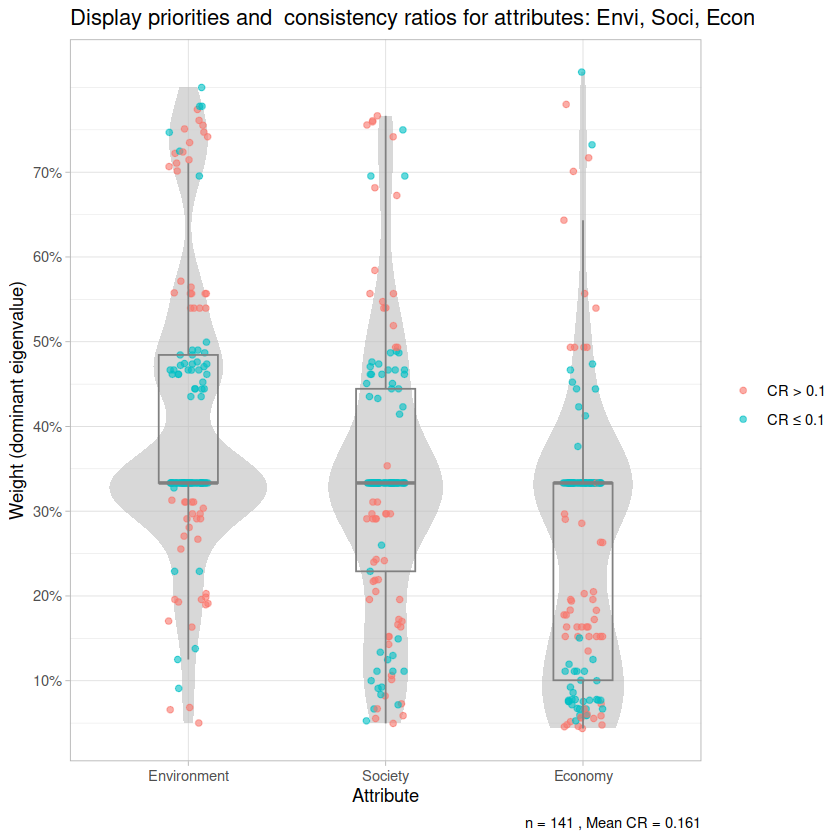

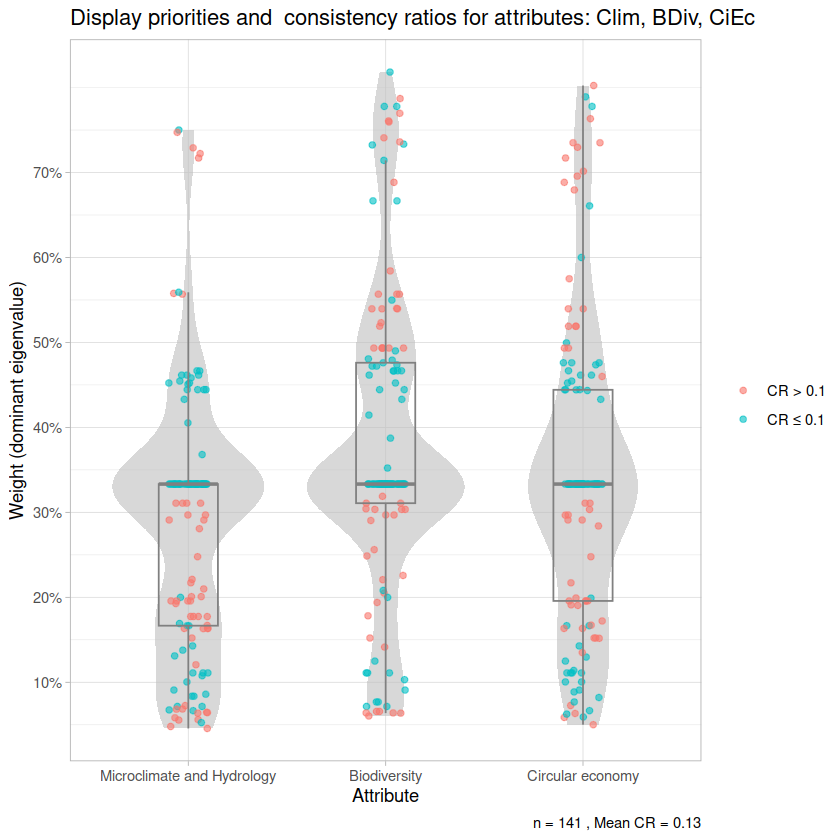

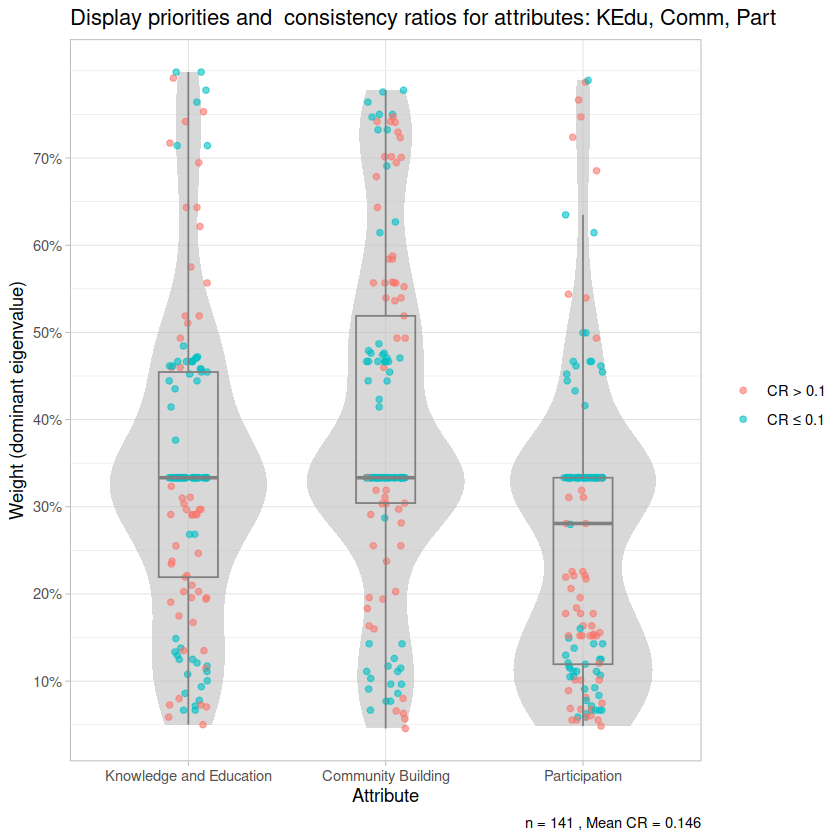

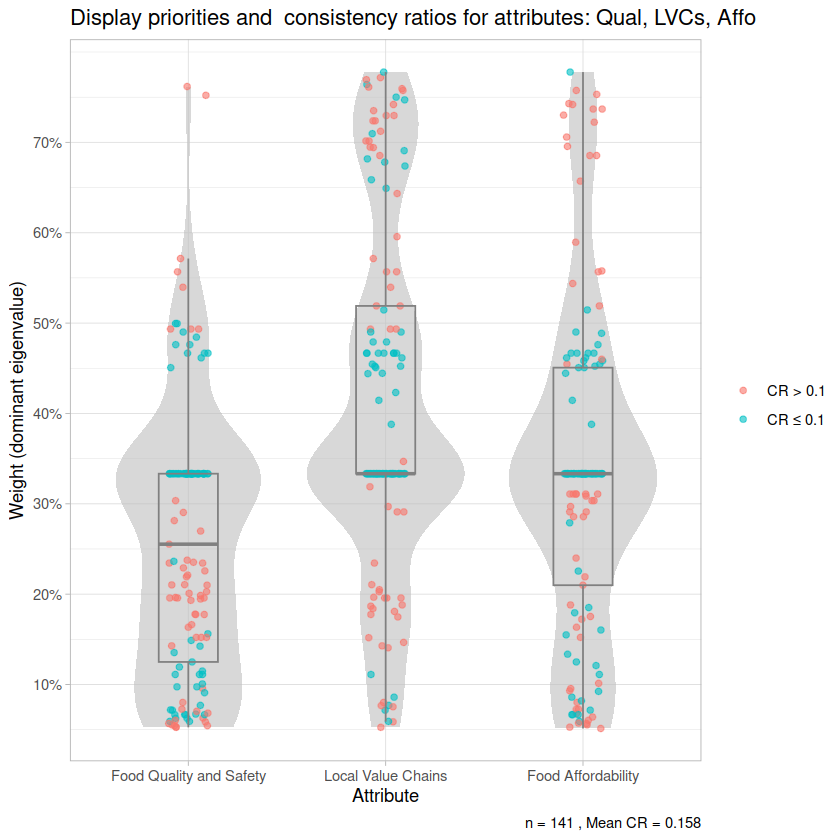

In [51]:
func_process_ahpsurvey(df_csvInputFiles_all, "all", str_input_path_ahp,
                       str_output_path_ahp, df_attributes_labels)

### Participants of city administrations

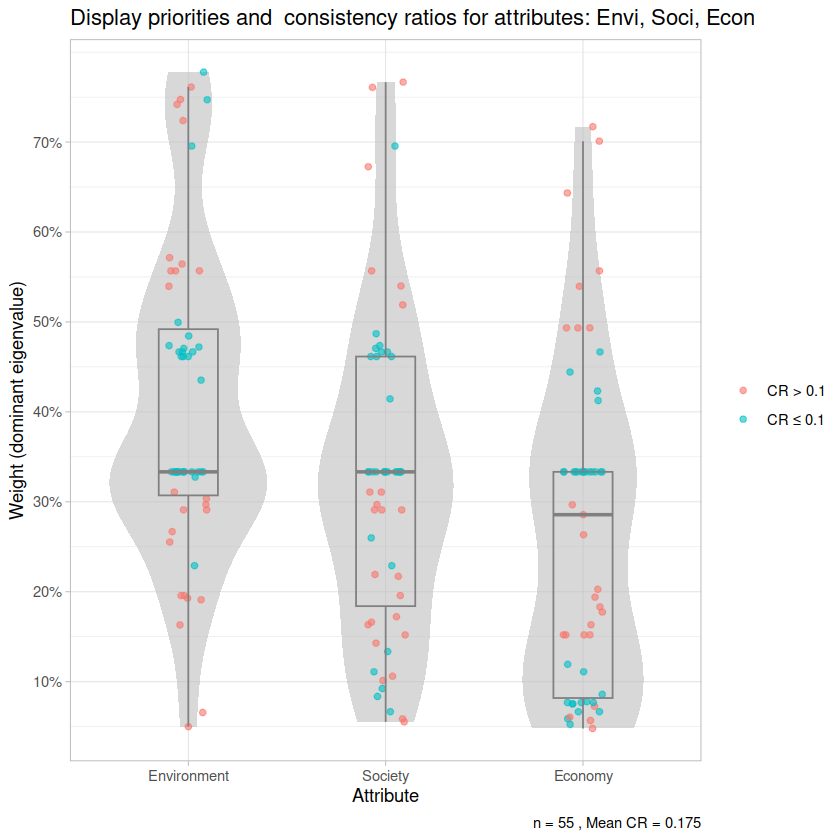

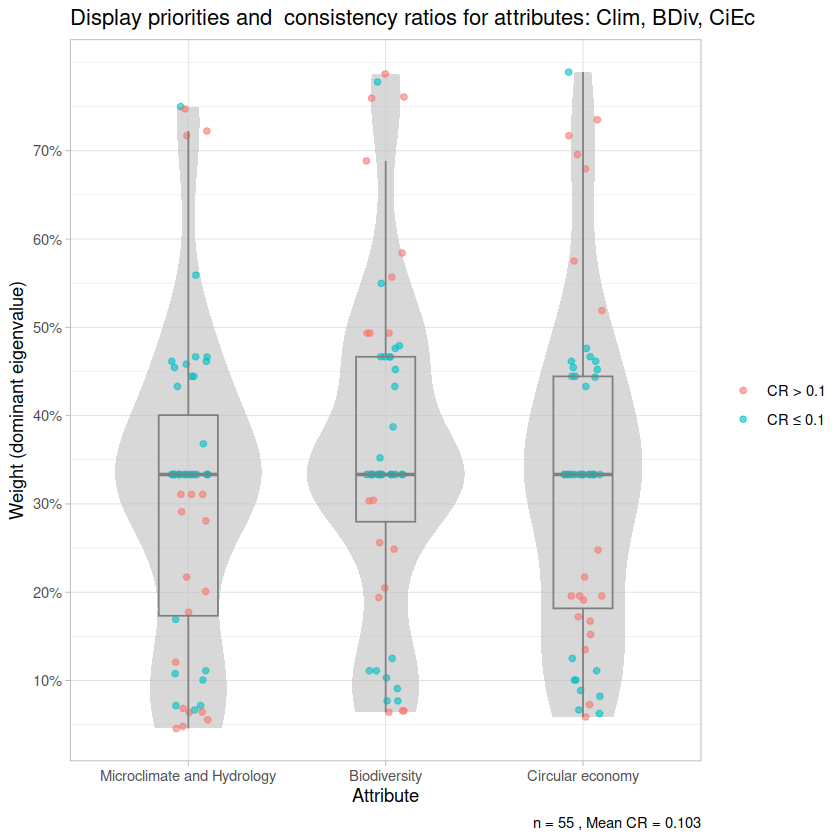

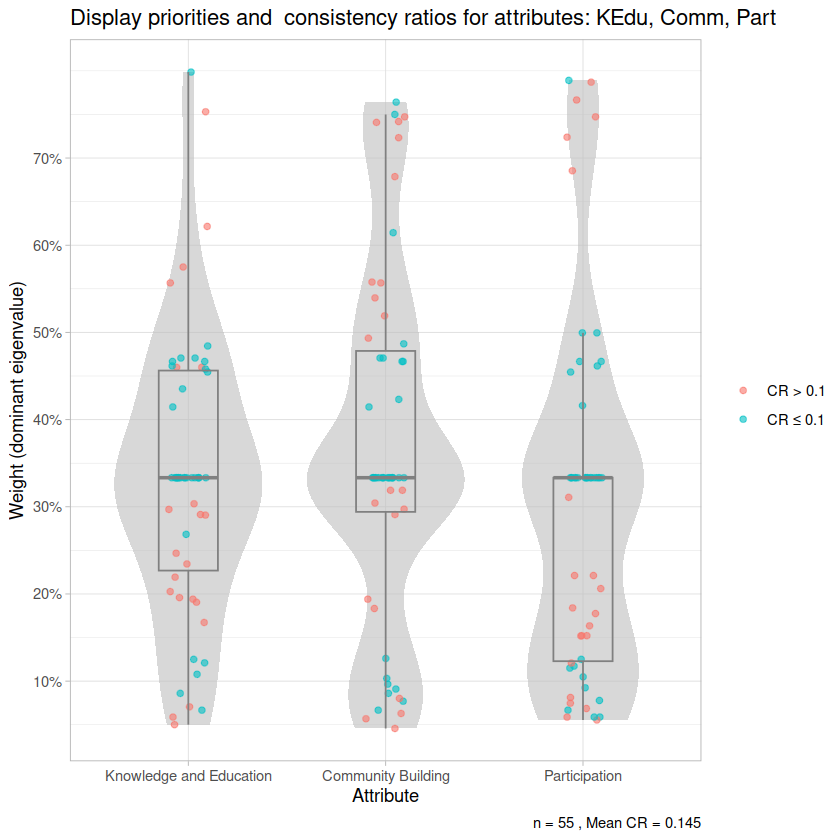

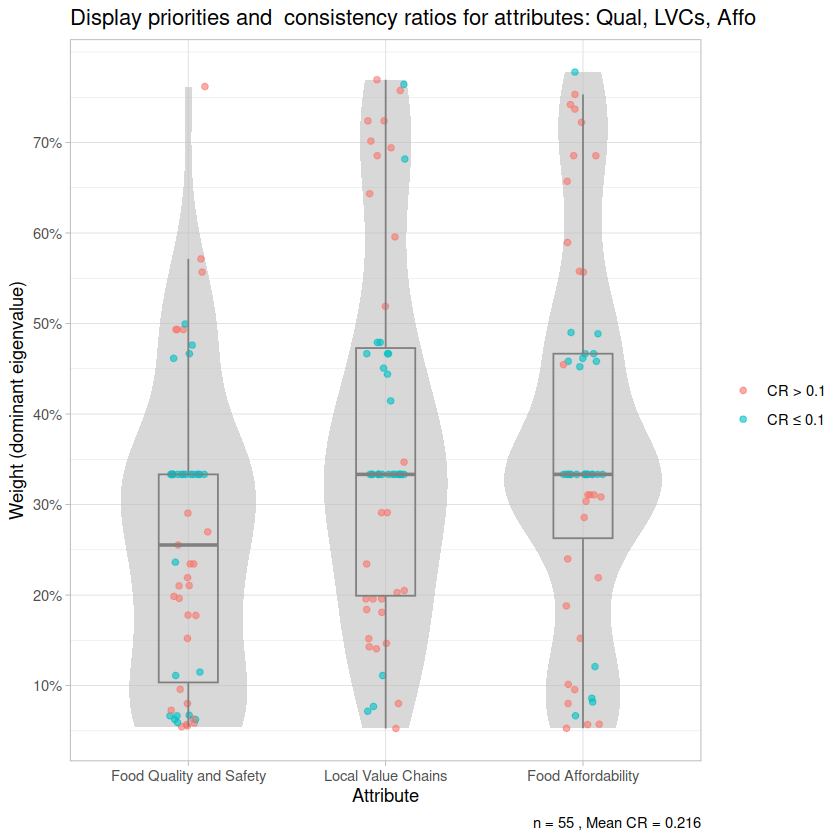

In [52]:
func_process_ahpsurvey(df_csvInputFiles_CA, "CA", str_input_path_ahp,
                       str_output_path_ahp, df_attributes_labels)

### Participants of non-governmental organizations

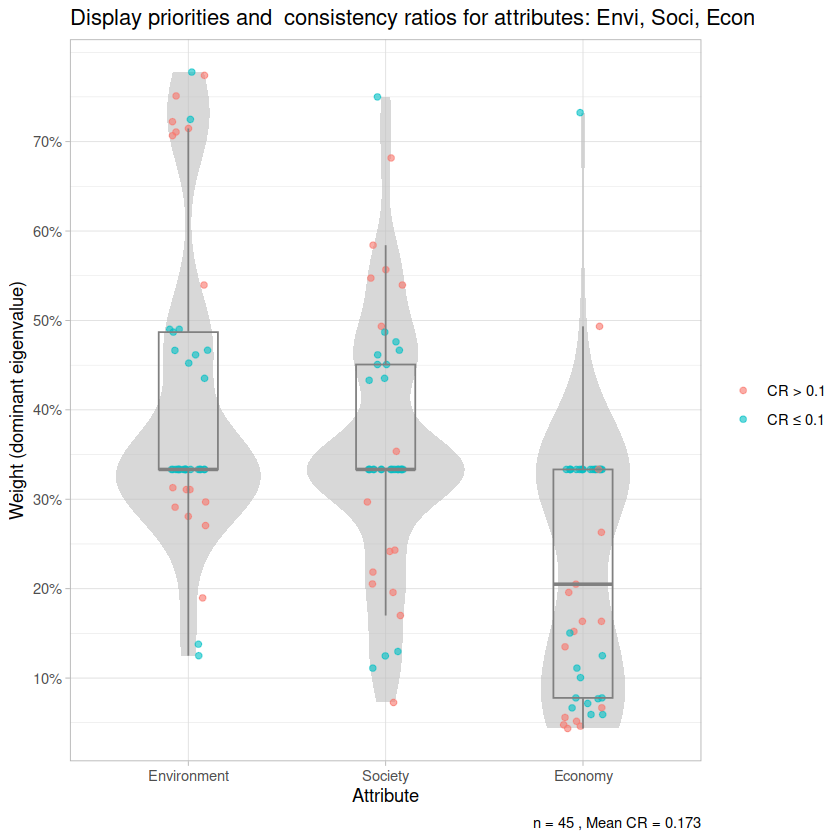

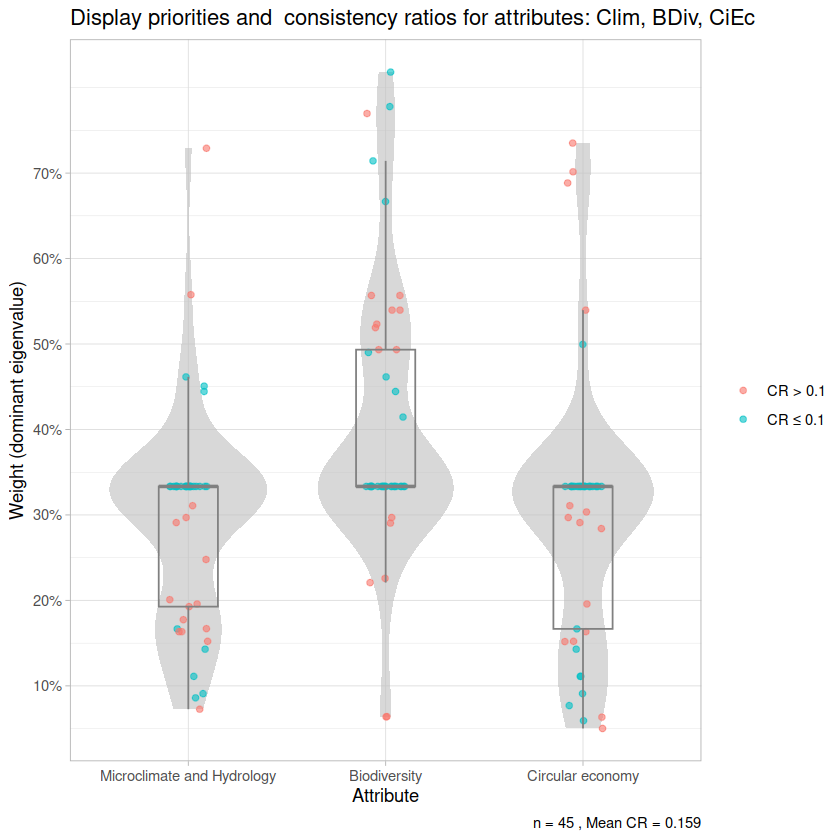

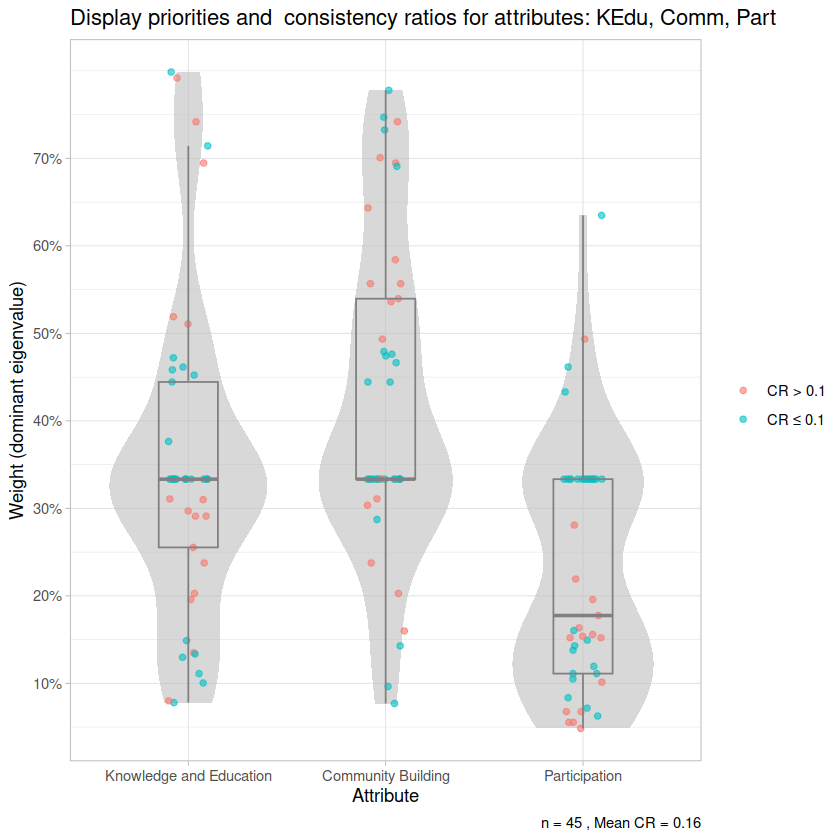

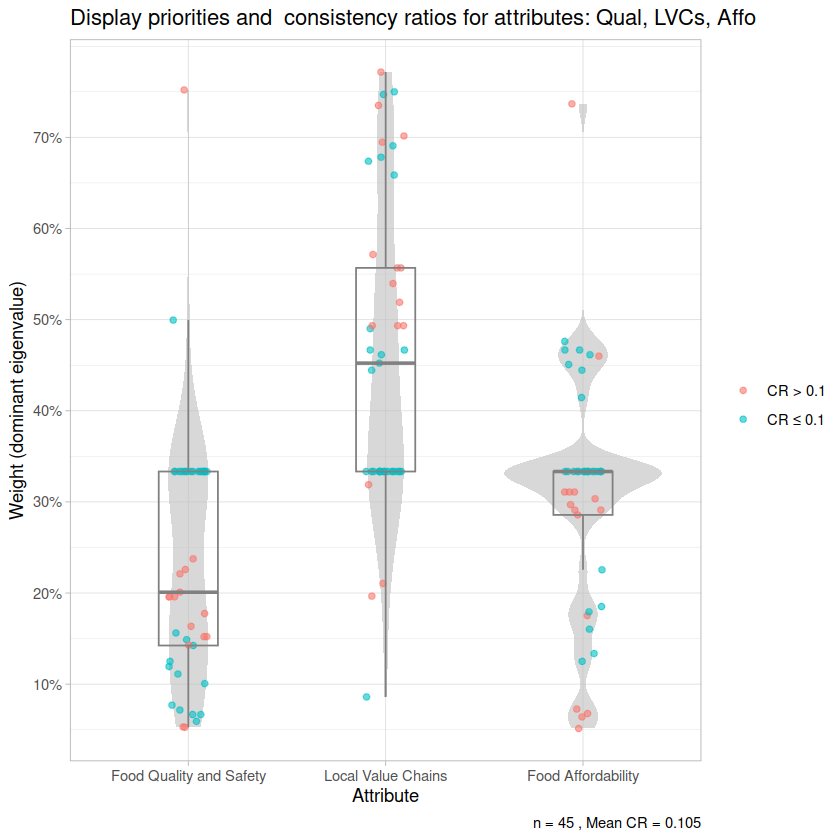

In [53]:
func_process_ahpsurvey(df_csvInputFiles_NGO, "NGO", str_input_path_ahp,
                       str_output_path_ahp, df_attributes_labels)

### Participants of practitioners and experts

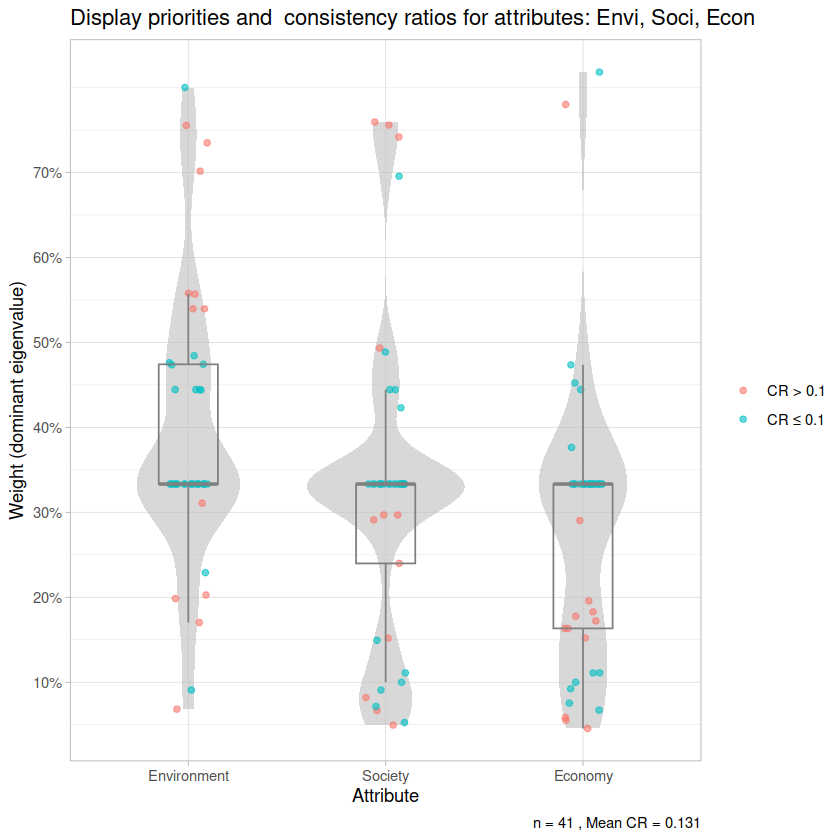

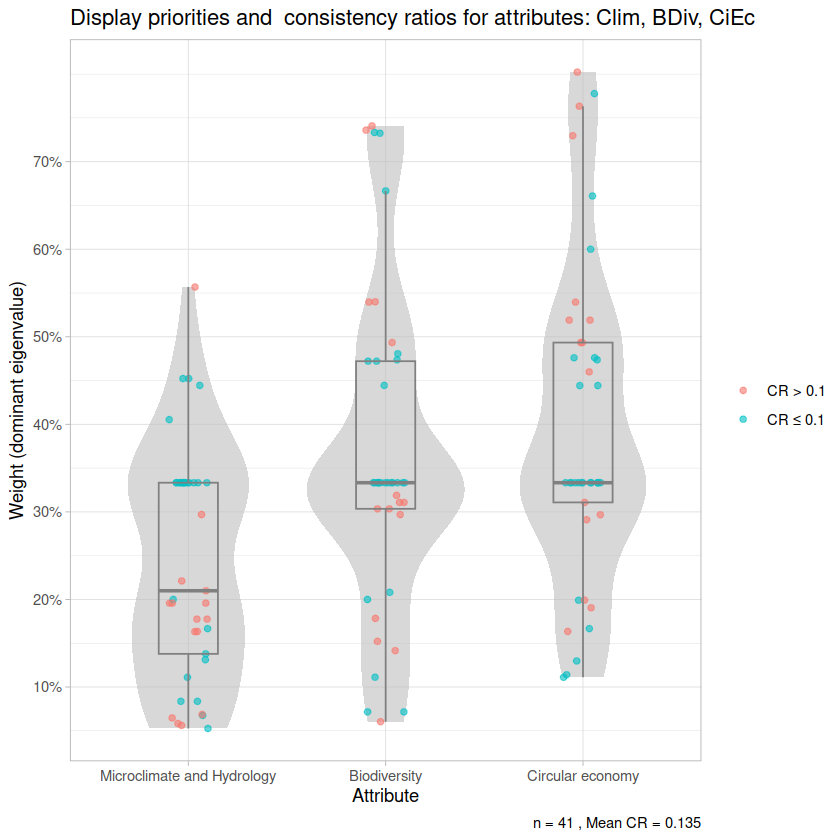

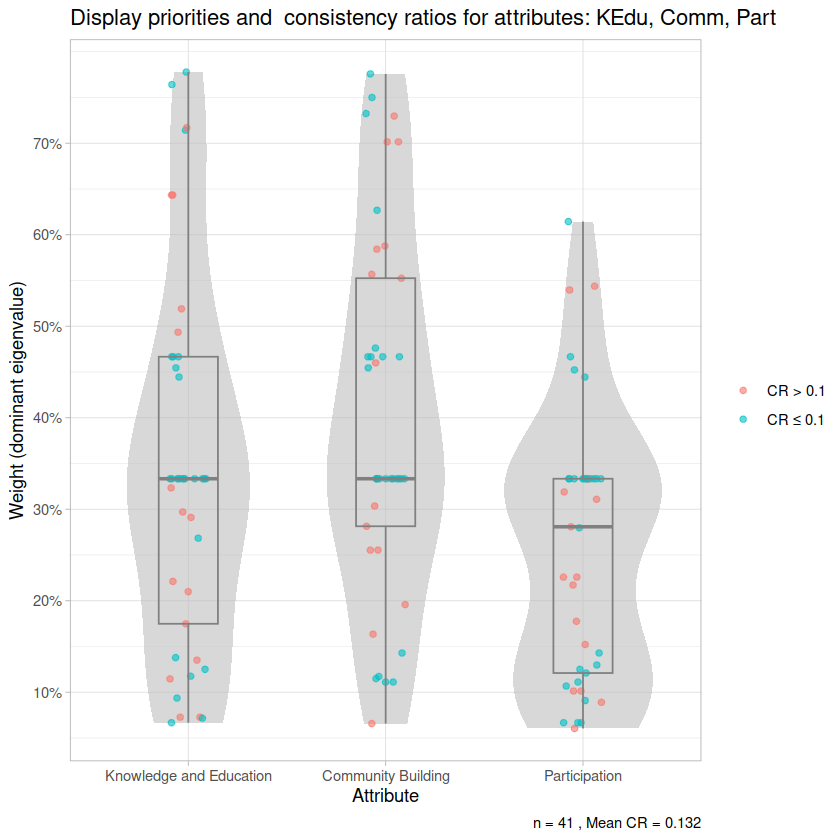

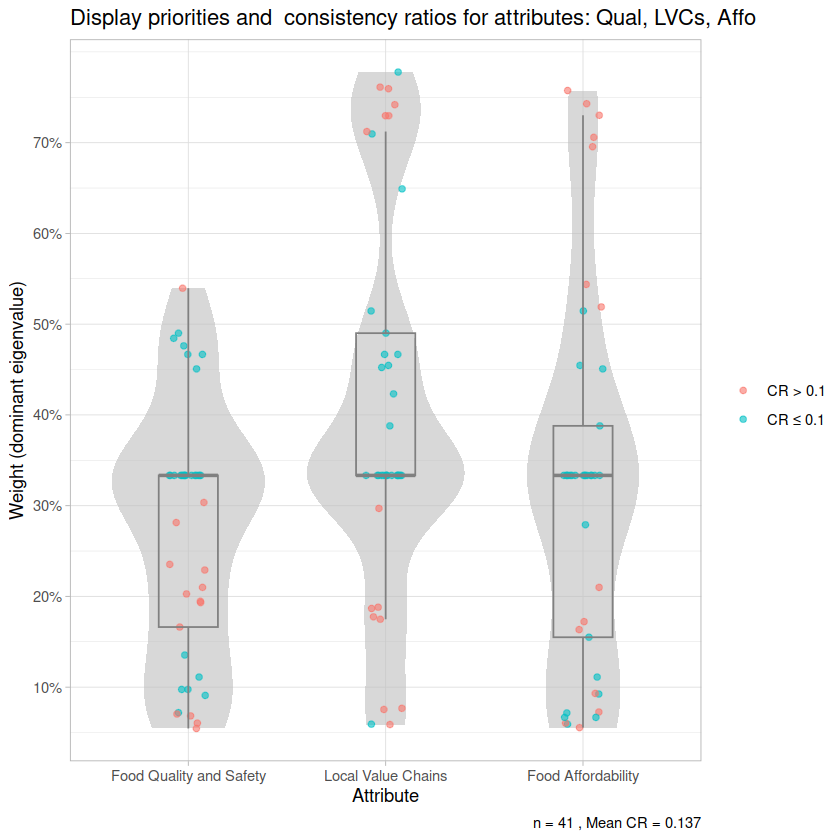

In [54]:
func_process_ahpsurvey(df_csvInputFiles_PE, "PE", str_input_path_ahp,
                       str_output_path_ahp, df_attributes_labels)

## Calculate aggregated preference weights for consistent datasets

In [55]:
func_calc_pref_weights(df_csvInputFiles_all, str_input_path_ahp,
                       df_attributes_labels)

Table: Aggregated weights for  criteria (main criteria)

|     | gmean.raw| gmean.norm|
|:----|---------:|----------:|
|Envi | 0.3739039|  0.4179807|
|Soci | 0.3023657|  0.3380094|
|Econ | 0.2182787|  0.2440099|
|Sum  | 0.8945482|  1.0000000|

Table: Aggregated weights for  environmental sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|Clim | 0.2741300|  0.3089871|   0.1291506|
|BDiv | 0.3291718|  0.3710277|   0.1550824|
|CiEc | 0.2838874|  0.3199852|   0.1337476|
|Sum  | 0.8871892|  1.0000000|   0.4179807|

Table: Aggregated weights for  social sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|KEdu | 0.3018698|  0.3512801|   0.1187360|
|Comm | 0.3212634|  0.3738480|   0.1263641|
|Part | 0.2362090|  0.2748719|   0.0929093|
|Sum  | 0.8593422|  1.0000000|   0.3380094|

Table: Aggregated weights for  economic sub-criteria

|     | gmean.raw| gmean.norm| gmean.total|
|:----|---------:|----------:|-----------:|
|Qual | 0.2329901|  0.2625724|   0.0640703|
|LVCs | 0.3666029|  0.4131498|   0.1008127|
|Affo | 0.2877435|  0.3242777|   0.0791270|
|Sum  | 0.8873365|  1.0000000|   0.2440099|

# Summary and outlook